# Experiments 203

***Changelog:***
- Validation metrics added
- New network architectures added. 

In [1]:
cd ~/downloads/Pedro-Pineapple/forecasting

/home/aargaez/downloads/Pedro-Pineapple/forecasting


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import environments
import numpy as np
from stable_baselines3 import A2C
from dataclasses import dataclass
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix
)
from json import dumps
from typing import Tuple, Union, List

In [3]:
def data_splitter(
    raw_data: pd.DataFrame,
    proportion: int = 0.7,
    init: Union[int, Tuple[int, int]] = None,
    end: Union[int, Tuple[int, int]] = None
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the raw time series data set.
    """
    if isinstance(init, int) and isinstance(end, int):
        train = raw_data.iloc[:init]
        test = raw_data.iloc[end:]
    
    if isinstance(init, tuple) and isinstance(end, tuple):
        train = raw_data.iloc[init[0]:init[1]]
        test = raw_data.iloc[end[0]:end[1]]
    
    if not init and not end:
        splitter = round(raw_data.shape[0] * proportion)
        train, test = raw_data.iloc[:splitter], raw_data.iloc[splitter:]

    return train, test

def create_labels(
    x: pd.Series,
    bins: List[float],
    labels: List[Union[str, float, int]]
) -> Tuple[pd.Series, pd.Series]:
    """
    Create the labels based on a given pd.Series.
    """
    # Relative differences.
    relative_diff = x.pct_change(periods=1).fillna(value=0)
    # Percentual.
    perc_relative_diff = relative_diff * 100
    # Cut labels.
    all_labels = pd.cut(
        x=perc_relative_diff,
        bins=bins,
        labels=labels,
        right=False
    )

    return all_labels, perc_relative_diff

def evaluation_metrics(
    y_true: pd.Series,
    y_pred: pd.Series,
    target_names: List[Union[int,str,float]]
) -> Union[str, dict]:
    """
    Creates the confusion matrix from Scikit-learn.
    """
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=target_names
    )
    disp.plot()
    plt.show()

    report = classification_report(
        y_true=y_true,
        y_pred=y_pred,
        target_names=target_names,
        output_dict=True
    )
    return report

In [4]:
# Time series parameters.
@dataclass
class PARAMETERS:
    TIMESTEPS = 200
    WINDOW_SIZE = 5
    DATA_PATH = '~/downloads/Pedro-Pineapple/data/SPY_20172023.csv'

In [5]:
# Read data.
data = pd.read_csv(PARAMETERS.DATA_PATH)
data.columns = data.columns.str.lower()

In [6]:
# TODO: Add statistical bins.
data['labels'], data['perc_relative_diff'] = create_labels(
    x=data['close'],
    bins=[-float('inf'), -0.1, 0.1, float('inf')],
    labels=[0, 1, 2]
)

In [7]:
df_train, df_test = data_splitter(raw_data=data)

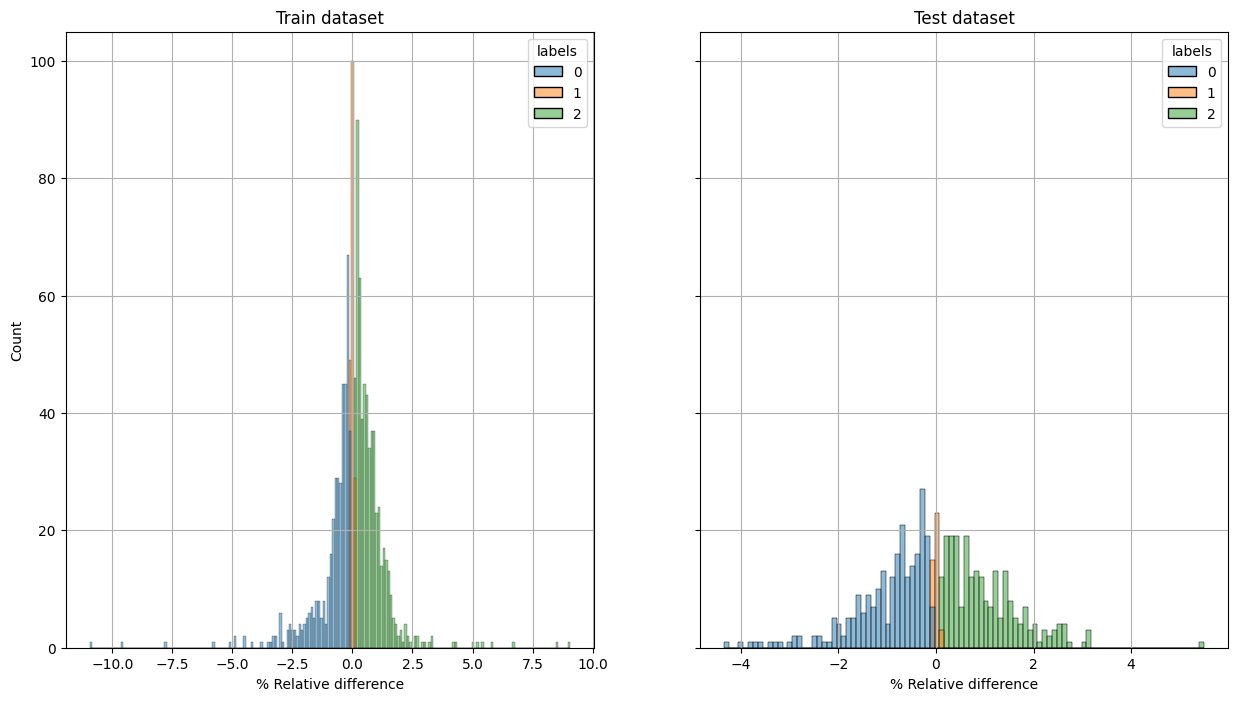

In [8]:
# Visualize the relative percentage changes.
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True,  figsize=(15, 8))

sns.histplot(data=df_train, binwidth=0.1, x="perc_relative_diff", hue="labels", ax=ax1)
ax1.set_ylabel('Count')
ax1.set_xlabel('% Relative difference')
ax1.set_title('Train dataset')
ax1.grid()

sns.histplot(data=df_test, binwidth=0.1, x="perc_relative_diff", hue="labels", ax=ax2)
ax2.set_ylabel('Count')
ax2.set_xlabel('% Relative difference')
ax2.set_title('Test dataset')
ax2.grid()

In [9]:
# Create the environment.
env = environments.Forecasting(
    df=df_train, window_size=PARAMETERS.WINDOW_SIZE
)

In [10]:
# Random walk.
state = env.reset(seed=2008)

while True:
    # Sample action from space.
    action = env.action_space.sample()
    n_state, reward, done, truncated, info = env.step(
        action=action
    )

    if done or truncated:
        print('info', info, '\n')
        break

info {'total_reward': 822.8999481201172} 



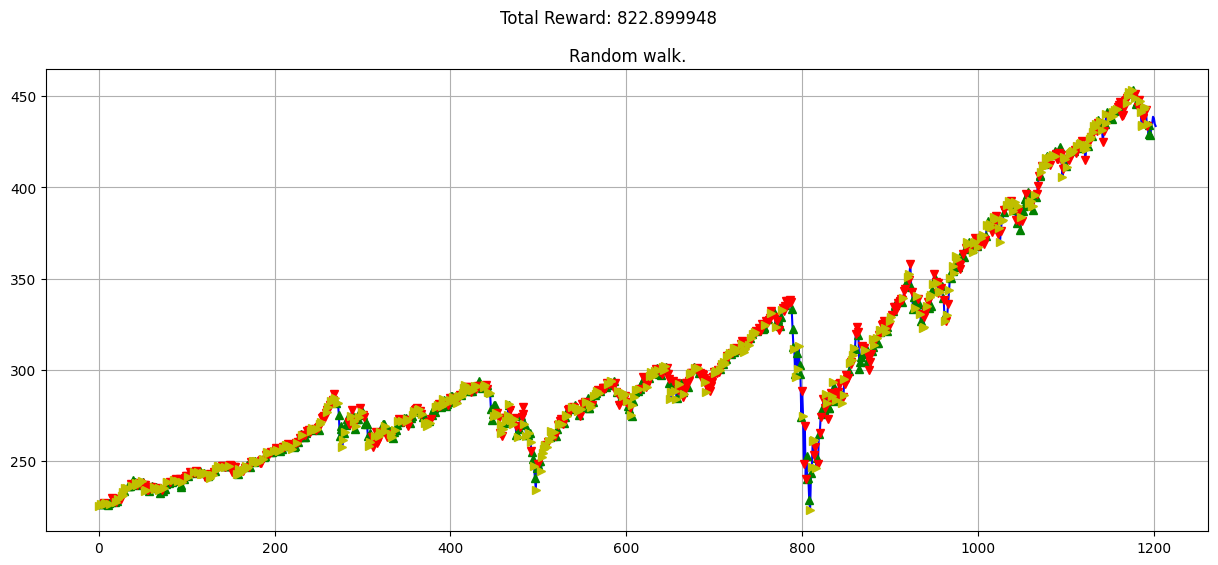

In [11]:
plt.figure(figsize=(15, 6))
plt.cla()
env.render_all(title='Random walk.')
plt.show()

In [12]:
y_true, y_pred = df_train['labels'].to_numpy()[PARAMETERS.WINDOW_SIZE + 1:], env.actions_history

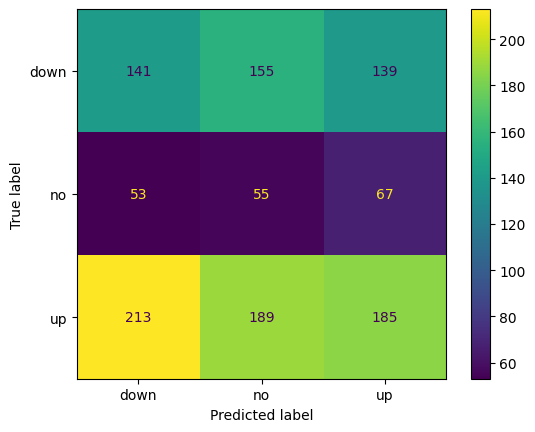

In [13]:
performance = evaluation_metrics(
    y_true=y_true,
    y_pred=y_pred,
    target_names=['down', 'no', 'up']
)

In [14]:
print(dumps(performance, indent=4))

{
    "down": {
        "precision": 0.3464373464373464,
        "recall": 0.32413793103448274,
        "f1-score": 0.33491686460807596,
        "support": 435.0
    },
    "no": {
        "precision": 0.13784461152882205,
        "recall": 0.3142857142857143,
        "f1-score": 0.19163763066202089,
        "support": 175.0
    },
    "up": {
        "precision": 0.4731457800511509,
        "recall": 0.3151618398637138,
        "f1-score": 0.3783231083844581,
        "support": 587.0
    },
    "accuracy": 0.3182957393483709,
    "macro avg": {
        "precision": 0.31914257933910645,
        "recall": 0.31786182839463695,
        "f1-score": 0.30162586788485163,
        "support": 1197.0
    },
    "weighted avg": {
        "precision": 0.37807821688205107,
        "recall": 0.3182957393483709,
        "f1-score": 0.33525571102092194,
        "support": 1197.0
    }
}


In [15]:
# Train Environment
model = A2C('MlpPolicy', env, verbose=1) 
model.learn(total_timesteps=PARAMETERS.TIMESTEPS)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [16]:
env = environments.Forecasting(
    df=df_test, window_size=PARAMETERS.WINDOW_SIZE
)

observation, info = env.reset()

while True: 
    observation = observation[np.newaxis, ...]
    action, _states = model.predict(observation)
    observation, rewards, done, truncated, info = env.step(action)
    if done or truncated:
        print('info', info, '\n')
        break

info {'total_reward': 922.8401489257812} 



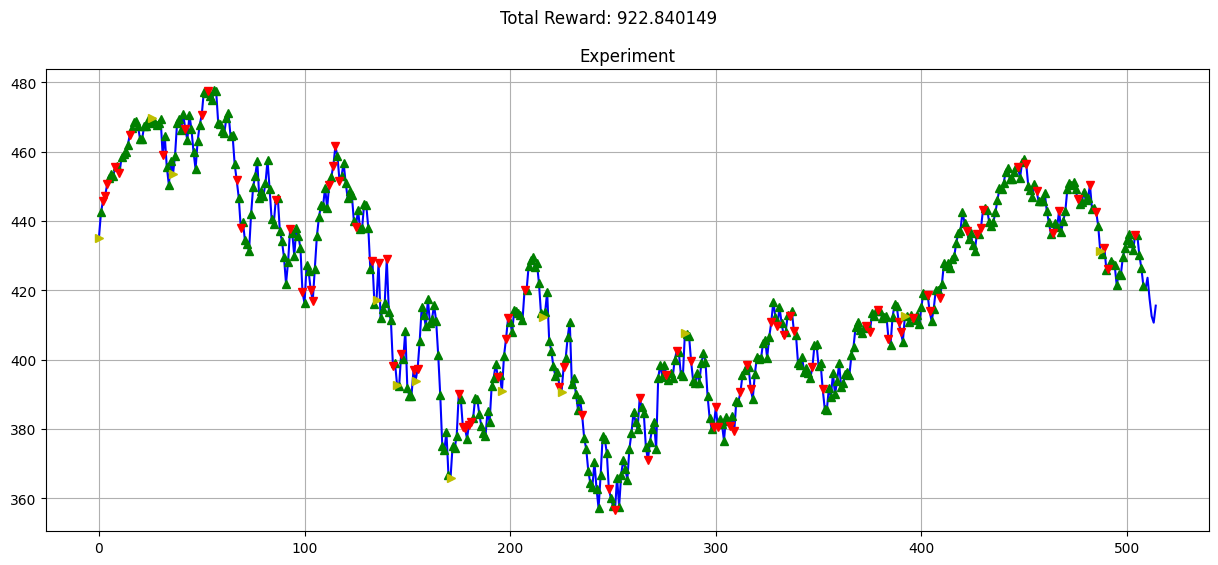

In [17]:
plt.figure(figsize=(15, 6))
plt.cla()
env.render_all(title='Experiment')
plt.show()

In [18]:
y_true, y_pred = df_test['labels'].to_numpy()[PARAMETERS.WINDOW_SIZE + 1:], np.concatenate(env.actions_history)

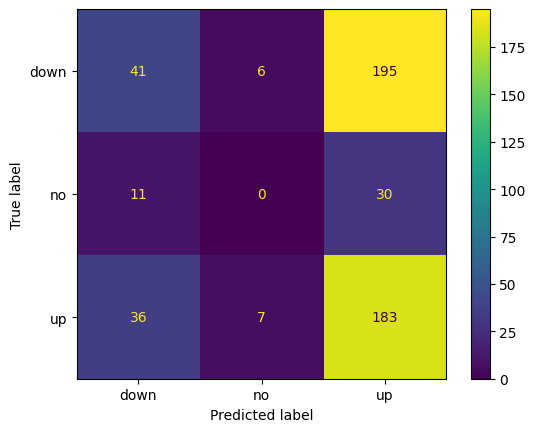

In [19]:
performance = evaluation_metrics(
    y_true=y_true,
    y_pred=y_pred,
    target_names=['down', 'no', 'up']
)

In [20]:
print(dumps(performance, indent=4))

{
    "down": {
        "precision": 0.4659090909090909,
        "recall": 0.16942148760330578,
        "f1-score": 0.2484848484848485,
        "support": 242.0
    },
    "no": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 41.0
    },
    "up": {
        "precision": 0.4485294117647059,
        "recall": 0.8097345132743363,
        "f1-score": 0.5772870662460569,
        "support": 226.0
    },
    "accuracy": 0.4400785854616896,
    "macro avg": {
        "precision": 0.3048128342245989,
        "recall": 0.3263853336258807,
        "f1-score": 0.2752573049103018,
        "support": 509.0
    },
    "weighted avg": {
        "precision": 0.42066335375014446,
        "recall": 0.4400785854616896,
        "f1-score": 0.3744601381236586,
        "support": 509.0
    }
}


## Performance explanation

Precision = $\frac{TP}{TP + FP}$

Recall =  $\frac{TP}{TP + FN}$

F1 = $\frac{2}{Precision^{-1} + Recall^{-1}}$